In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### 1. read_csv 並做一點處理

In [4]:
df_train = pd.read_csv(
    'dataset/train.csv',usecols=[1,2,3,4,5],
    dtype={'onpromotion':bool,
           'store_nbr':int,
           'item_nbr':int},
    parse_dates=['date'],
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    skiprows=range(1,66458909)  # 2016-01-01   
)

In [5]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2016-01-01,25,105574,2.564949,False
1,2016-01-01,25,105575,2.302585,False
2,2016-01-01,25,105857,1.386294,False
3,2016-01-01,25,108634,1.386294,False
4,2016-01-01,25,108701,1.098612,True


In [6]:
df_train.isnull().any()

date           False
store_nbr      False
item_nbr       False
unit_sales     False
onpromotion    False
dtype: bool

In [7]:
df_test = pd.read_csv(
    'dataset/test.csv',usecols=[0,1,2,3,4],
    dtype={'onpromotion':bool,
           'store_nbr':int,
           'item_nbr':int},
    parse_dates=['date']
).set_index(
    ['store_nbr','item_nbr','date']
)
df_test.head()

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [8]:
items = pd.read_csv(
    "dataset/items.csv",
).set_index("item_nbr")
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103501,CLEANING,3008,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1


In [9]:
stores = pd.read_csv(
    "dataset/stores.csv",
).set_index('store_nbr')

stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


#### 2. LabelEncode

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
le = LabelEncoder()

In [12]:
items['family'] = le.fit_transform(items['family'].values)
stores['city'] = le.fit_transform(stores['city'].values)
stores['state'] = le.fit_transform(stores['state'].values)
stores['type'] = le.fit_transform(stores['type'].values)

In [13]:
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103501,7,3008,0
103520,12,1028,0
103665,5,2712,1


In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4100 entries, 96995 to 2134244
Data columns (total 3 columns):
family        4100 non-null int64
class         4100 non-null int64
perishable    4100 non-null int64
dtypes: int64(3)
memory usage: 128.1 KB


#### 3. 將欄位攤開, 沒有銷售紀錄的補0

In [15]:
df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]

In [16]:
promo_train_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_train_2017.columns = promo_train_2017.columns.get_level_values(1)

In [17]:
promo_test_2017 = df_test[['onpromotion']].unstack(level=-1).fillna(False)
promo_test_2017.columns = promo_test_2017.columns.get_level_values(1)
promo_test_2017 = promo_test_2017.reindex(promo_train_2017.index).fillna(False)

In [18]:
promo_2017 = pd.concat([promo_train_2017,promo_test_2017],axis=1)

In [19]:
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False        True       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False        True       False       False   

date                2017-01-09  2017-01-10     ...      2017-08-22  \
store_nbr item_nbr                             ...                   
1         96995          False       False     ...           False   
          99197          False       False     ...           False   
          103520         False       False     ...           False   
          103665         False       False     ...           False   
          105574         False       False     ...           False   

date                2017-08-23  2017-08-24  2017-08-25  2017-08-26  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-27  2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                              
1         96995          False       False       False       False       False  
          99197          False       False       False       False       False  
          103520         False       False       False       False       False  
          103665         False       False       False       False       False  
          105574         False       False       False       False       False  

[5 rows x 243 columns]

In [20]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

In [21]:
df_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995       0.000000    0.000000     ...        1.098612   
          99197       0.000000    0.693147     ...        0.000000   
          103520      0.693147    0.693147     ...        0.000000   
          103665      0.000000    2.079442     ...        0.693147   
          105574      1.386294    2.302585     ...        0.000000   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       1.098612    0.000000    0.000000    0.693147   
          99197       1.098612    0.000000    1.098612    0.000000   
          103520      0.000000    1.386294    0.000000    1.386294   
          103665      1.098612    0.000000    2.079442    2.302585   
          105574      1.791759    2.079442    1.945910    2.397895   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995       0.000000    0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.693147    0.000000    0.000000  
          103665      1.098612    0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    1.791759    0.000000    1.386294    1.609438  

[5 rows x 227 columns]

In [22]:
#依照df_train的item_nbr重新排序items, stores
items = items.reindex(df_2017.index.get_level_values(1))
stores = stores.reindex(df_2017.index.get_level_values(0))

In [23]:
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103520,12,1028,0
103665,5,2712,1
105574,12,1045,0


In [24]:
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13


In [25]:
df_2017_item = df_2017.groupby('item_nbr')[df_2017.columns].sum()

In [26]:
df_2017_item.head()

date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,...,2017-08-06 00:00:00,2017-08-07 00:00:00,2017-08-08 00:00:00,2017-08-09 00:00:00,2017-08-10 00:00:00,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00
item_nbr,,,,,,,,,,,,,,,,,,,,,
96995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.662960,7.454720,2.484907,5.950643,5.545177,8.841014,7.742402,4.969813,7.167038,7.742402
99197,0.693147,17.422746,16.604036,20.569303,16.203025,16.278613,14.775909,17.317386,14.986630,15.833927,...,3.178054,4.969813,3.178054,4.969813,2.079442,2.197225,1.386294,2.079442,0.000000,0.000000
103501,0.000000,55.868320,54.627085,42.810313,39.555298,35.717635,47.208504,47.542538,40.189274,39.200893,...,38.578235,33.531460,35.296421,35.584104,26.270815,32.776619,34.416498,36.546914,34.773173,35.512841
103520,0.000000,38.875486,35.822995,34.979211,42.252967,51.397412,49.505990,33.846832,33.336007,31.741073,...,35.630624,32.567752,47.213872,41.198030,43.569852,48.697330,47.015385,39.070042,33.798042,40.030669
103665,2.079442,56.225402,40.233610,46.138063,38.100507,49.690810,54.725492,54.286513,39.602739,35.899957,...,50.919628,41.262812,34.711732,34.095546,48.162787,50.980653,39.807856,39.016553,34.262348,35.741351


In [27]:
promo_2017_item = promo_2017.groupby('item_nbr')[promo_2017.columns].sum()

In [28]:
promo_2017_item.head()

date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,...,2017-08-22 00:00:00,2017-08-23 00:00:00,2017-08-24 00:00:00,2017-08-25 00:00:00,2017-08-26 00:00:00,2017-08-27 00:00:00,2017-08-28 00:00:00,2017-08-29 00:00:00,2017-08-30 00:00:00,2017-08-31 00:00:00
item_nbr,,,,,,,,,,,,,,,,,,,,,
96995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
103520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
103665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0


In [29]:
df_2017_store_class = df_2017.reset_index()
df_2017_store_class['class'] = items['class'].values
df_2017_store_class_index = df_2017_store_class[['class', 'store_nbr']]
df_2017_store_class = df_2017_store_class.groupby(['class', 'store_nbr'])[df_2017.columns].sum()

In [30]:
df_2017_store_class.head()

date             2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
class store_nbr                                                               
1002  1                 0.0    6.291569   11.901285    9.939627   12.817576   
      2                 0.0   27.836761   21.942946   23.265525   20.405583   
      3                 0.0   42.484074   29.286804   35.991684   29.124900   
      4                 0.0   28.353452   21.278199   22.805993   20.207757   
      5                 0.0   19.157935   15.744315   14.909440   12.177673   

date             2017-01-06  2017-01-07  2017-01-08  2017-01-09  2017-01-10  \
class store_nbr                                                               
1002  1           10.961278   13.708549    7.454720   18.598319   12.322254   
      2           23.207544   32.629193   33.057327   18.878450   24.403008   
      3           31.628492   36.412191   32.819483   27.527092   26.893368   
      4           19.822911   24.720218   31.524160   21.634874   17.617490   
      5           12.765460   12.306750   14.427014   15.168951   12.465355   

date                ...      2017-08-06  2017-08-07  2017-08-08  2017-08-09  \
class store_nbr     ...                                                       
1002  1             ...        6.068426   11.966952   13.458607   11.431281   
      2             ...       28.459131   25.885741   22.351737   21.326989   
      3             ...       38.142670   27.082659   30.859413   28.748667   
      4             ...       26.304582   10.961278   17.278515   13.223041   
      5             ...       12.647677   13.969433   11.901285   15.333254   

date             2017-08-10  2017-08-11  2017-08-12  2017-08-13  2017-08-14  \
class store_nbr                                                               
1002  1           13.367622    5.545177   13.628506    5.375278   18.639141   
      2           16.401095   26.828830   27.567914   25.059788   21.576931   
      3           30.232542   36.638416   31.272846   32.256757   33.608285   
      4           17.735273   19.822911   16.806560   23.187741   16.267563   
      5           13.851650   10.332669   14.416963   15.538049   11.192390   

date             2017-08-15  
class store_nbr              
1002  1           10.450452  
      2           24.121024  
      3           24.929109  
      4           16.267563  
      5           11.443704  

[5 rows x 227 columns]

In [31]:
df_2017_promo_store_class = promo_2017.reset_index()
df_2017_promo_store_class['class'] = items['class'].values
df_2017_promo_store_class_index = df_2017_promo_store_class[['class', 'store_nbr']]
df_2017_promo_store_class = df_2017_promo_store_class.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()

In [32]:
df_2017_promo_store_class.head()

date             2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
class store_nbr                                                               
1002  1                 0.0         0.0         0.0         0.0         0.0   
      2                 0.0         0.0         0.0         0.0         0.0   
      3                 0.0         0.0         0.0         0.0         0.0   
      4                 0.0         0.0         0.0         0.0         0.0   
      5                 0.0         0.0         0.0         0.0         0.0   

date             2017-01-06  2017-01-07  2017-01-08  2017-01-09  2017-01-10  \
class store_nbr                                                               
1002  1                 0.0         0.0         0.0         0.0         0.0   
      2                 0.0         0.0         0.0         0.0         0.0   
      3                 0.0         0.0         0.0         0.0         0.0   
      4                 0.0         0.0         0.0         0.0         0.0   
      5                 0.0         0.0         0.0         0.0         1.0   

date                ...      2017-08-22  2017-08-23  2017-08-24  2017-08-25  \
class store_nbr     ...                                                       
1002  1             ...             1.0         1.0         1.0         1.0   
      2             ...             1.0         1.0         1.0         1.0   
      3             ...             1.0         1.0         1.0         1.0   
      4             ...             1.0         1.0         1.0         1.0   
      5             ...             0.0         1.0         1.0         0.0   

date             2017-08-26  2017-08-27  2017-08-28  2017-08-29  2017-08-30  \
class store_nbr                                                               
1002  1                 1.0         1.0         1.0         1.0         1.0   
      2                 1.0         1.0         1.0         1.0         1.0   
      3                 1.0         1.0         1.0         1.0         1.0   
      4                 1.0         1.0         1.0         1.0         1.0   
      5                 1.0         1.0         1.0         1.0         1.0   

date             2017-08-31  
class store_nbr              
1002  1                 1.0  
      2                 1.0  
      3                 1.0  
      4                 2.0  
      5                 0.0  

[5 rows x 243 columns]

#### 4. 切分train/val/test

In [33]:
from datetime import date, timedelta, datetime

In [34]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [93]:
def prepare_dataset(df, promo_df, t2017, is_train=True, name_prefix=None):
    X = {
        "promo_3_2017": get_timespan(promo_df, t2017, 3, 3).sum(axis=1).values,
        "promo_5_2017": get_timespan(promo_df, t2017, 5, 5).sum(axis=1).values,
        "promo_7_2017": get_timespan(promo_df, t2017, 7, 7).sum(axis=1).values,
        "promo_14_2017": get_timespan(promo_df, t2017, 14, 14).sum(axis=1).values,
        "promo_30_2017": get_timespan(promo_df, t2017, 30, 30).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_df, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_df, t2017, 140, 140).sum(axis=1).values,
        "promo_3_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 3).sum(axis=1).values,
        "promo_7_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 7).sum(axis=1).values,
        "promo_14_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 14).sum(axis=1).values,
    }


    for i in [3, 5, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
#         X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values


    for i in [7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

        tmp = get_timespan(promo_df, t2017, i, i)
        #X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    tmp = get_timespan(promo_df, t2017 + timedelta(days=16), 15, 15)
    X['has_promo_days_in_after_15_days'] = (tmp > 0).sum(axis=1).values
    X['last_has_promo_day_in_after_15_days'] = i - ((tmp > 0) * np.arange(15)).max(axis=1).values
    X['first_has_promo_day_in_after_15_days'] = ((tmp > 0) * np.arange(15, 0, -1)).max(axis=1).values

    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df, t2017, 140-i, 20, freq='7D').mean(axis=1).values

    for i in range(16):
        X["promo_{}".format(i)] = promo_df[t2017 + timedelta(days=i)].values.astype(np.uint8)

    X = pd.DataFrame(X)

    if is_train:
        y = df[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

In [94]:
datetime(2017,6,21)+timedelta(35)

datetime.datetime(2017, 7, 26, 0, 0)

In [154]:
print("Preparing dataset...")
# 5/31後八週; 6/21後四週

t2017 = date(2017, 6, 21)
X_l, y_l = [], []
for i in range(4):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(df_2017, promo_2017, t2017 + delta)

#     X_tmp2 = prepare_dataset(df_2017_item, promo_2017_item, t2017 + delta, is_train=False, name_prefix='item')
#     X_tmp2.index = df_2017_item.index
#     X_tmp2 = X_tmp2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

#     X_tmp3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, t2017 + delta, is_train=False, name_prefix='store_class')
#     X_tmp3.index = df_2017_store_class.index
#     X_tmp3 = X_tmp3.reindex(df_2017_store_class_index).reset_index(drop=True)

    
    #X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, items.reset_index(), stores.reset_index()], axis=1)
    X_tmp = pd.concat([X_tmp, items.reset_index(), stores.reset_index()], axis=1)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

#    del X_tmp2
    gc.collect()

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

Preparing dataset...


In [155]:
X_train.shape

(670060, 119)

In [158]:
periods = 16

X_val, y_val = prepare_dataset(df_2017, promo_2017, date(2017, 7, 26))
X_val = pd.concat([X_val, items.reset_index(), stores.reset_index()], axis=1)
# X_val2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 7, 26), is_train=False, name_prefix='item')
# X_val2.index = df_2017_item.index
# X_val2 = X_val2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

# X_val3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 7, 26), is_train=False, name_prefix='store_class')
# X_val3.index = df_2017_store_class.index
# X_val3 = X_val3.reindex(df_2017_store_class_index).reset_index(drop=True)

# X_val = pd.concat([X_val, X_val2, X_val3, items.reset_index(), stores.reset_index()], axis=1)

In [159]:
X_test = prepare_dataset(df_2017, promo_2017, date(2017, 8, 16), is_train=False)
X_test = pd.concat([X_test, items.reset_index(), stores.reset_index()], axis=1)
# X_test2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 8, 16), is_train=False, name_prefix='item')
# X_test2.index = df_2017_item.index
# X_test2 = X_test2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

# X_test3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 8, 16), is_train=False, name_prefix='store_class')
# X_test3.index = df_2017_store_class.index
# X_test3 = X_test3.reindex(df_2017_store_class_index).reset_index(drop=True)

# X_test = pd.concat([X_test, X_test2, X_test3, items.reset_index(), stores.reset_index()], axis=1)

In [160]:
import gc
gc.collect()

36

In [161]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(670060, 119)
(167515, 119)
(167515, 119)


In [51]:
del df_2017_item, promo_2017_item, df_2017_store_class, df_2017_promo_store_class, df_2017_store_class_index
gc.collect()

0

#### 5. model

正規化

In [162]:
from sklearn.preprocessing import StandardScaler

In [163]:
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val]))

X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)

X_train = X_train.values
X_val = X_val.values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [164]:
X_test[:] = scaler.transform(X_test)
X_test = X_test.values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[2], 1))

In [ ]:
#X_val = X_val.reshape((X_val.shape[0], X_val.shape[2], 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[2], 1))

建立模型

In [165]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense,  Dropout, Activation, Masking,Flatten
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM,Conv1D,MaxPooling1D
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [166]:
timesteps = X_train.shape[1]
data_dim = X_train.shape[2]

In [167]:
def build_model():
    model = Sequential()
    
    # PReLU是高級激活函數, 不要直接放進LSTM的 activation=, 建議要額外 model.add(PReLU())
    # BatchNormalization(), 將激活函數的輸出值壓在接近 0, 標準差 1, 可以加速收斂, 控制過擬合
    
    # Flatten層和 input層
    model.add(Flatten())
    model.add(Dense(512,input_shape=(timesteps, data_dim)))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    
    # 加第1層 Dense
    model.add(Dense(512))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))
      
    # 加第2層 Dense
    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))
    
    # 加第3層 Dense
    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    
    # 加第4層 Dense
    model.add(Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    
    # 加第5層 Dense
    model.add(Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    # 加第6層 Dense
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    # 加第7層 Dense
    model.add(Dense(32))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    model.add(Dense(32))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    # 加第8層 Dense
    model.add(Dense(16))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))
    
    
    model.add(Dense(1))
    
    return model

In [138]:
#  VGG
#  def build_model():
#         '''以Sequential()逐層疊加模型。'''
        
#         model = Sequential()
#         # conv block 1
#         model.add(Conv1D(32, (3), padding="same",activation="relu",
#                                      input_shape=(timesteps,data_dim)) )
#         model.add(Conv1D(32, (3),padding="same",activation="relu"))
#         model.add(MaxPooling1D(pool_size=(2)))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.2))
#         # conv block 2
#         model.add(Conv1D(64, (3), padding='same',activation="relu"))
#         model.add(Conv1D(64, (3),padding="same",activation="relu") )
#         model.add(MaxPooling1D(pool_size=(2)))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.1))
#         # conv block 3
#         model.add(Conv1D(128, (3), padding='same',activation="relu"))
#         model.add(Conv1D(128, (3),padding="same",activation="relu") )
#         model.add(MaxPooling1D(pool_size=(2)))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.05))
#         # conv block 4
#         model.add(Conv1D(256, (3), padding='same',activation="relu"))
#         model.add(Conv1D(256, (3),padding="same",activation="relu") )
#         model.add(MaxPooling1D(pool_size=(2)))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.05))
#         # dense block
#         """Dense層吃向量, 所以要用Flatten壓成一維向量
#         """
#         model.add(Flatten())
#         model.add(Dense(512,activation="relu"))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.05))
        
        
        
#         model.add(Dense(1))
        
#         return model

In [168]:
import time

In [169]:
t0 = time.time()
N_EPOCHS = 2000

val_pred = []
test_pred = []

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    y = y_train[:, i]
    y_mean = y.mean()
    xv = X_val
    yv = y_val[:, i]
    model = build_model()
    opt = optimizers.Adam(lr=0.0001) 
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        ]
   

    model.fit(X_train, y - y_mean, batch_size = 6400, epochs = N_EPOCHS, verbose=2,
              validation_data=(xv,yv-y_mean), callbacks=callbacks ) 

    val_pred.append(model.predict(X_val)+y_mean)
    test_pred.append(model.predict(X_test)+y_mean)

t1 = time.time()

Step 1
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 133s - loss: 1.4421 - mean_squared_error: 1.4421 - val_loss: 0.7421 - val_mean_squared_error: 0.7421
Epoch 2/2000
 - 9s - loss: 0.7788 - mean_squared_error: 0.7788 - val_loss: 0.5442 - val_mean_squared_error: 0.5442
Epoch 3/2000
 - 9s - loss: 0.6222 - mean_squared_error: 0.6222 - val_loss: 0.4358 - val_mean_squared_error: 0.4358
Epoch 4/2000
 - 9s - loss: 0.5587 - mean_squared_error: 0.5587 - val_loss: 0.3813 - val_mean_squared_error: 0.3813
Epoch 5/2000
 - 9s - loss: 0.5209 - mean_squared_error: 0.5209 - val_loss: 0.3511 - val_mean_squared_error: 0.3511
Epoch 6/2000
 - 9s - loss: 0.4967 - mean_squared_error: 0.4967 - val_loss: 0.3370 - val_mean_squared_error: 0.3370
Epoch 7/2000
 - 9s - loss: 0.4809 - mean_squared_error: 0.4809 - val_loss: 0.3287 - val_mean_squared_error: 0.3287
Epoch 8/2000
 - 9s - loss: 0.4655 - mean_squared_error: 0.4655 - val_loss: 0.3227 - val_mean_squared_error: 0.3227
Epoch 9/2000
 - 9s 

Step 2
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 135s - loss: 1.1261 - mean_squared_error: 1.1261 - val_loss: 0.5914 - val_mean_squared_error: 0.5914
Epoch 2/2000
 - 10s - loss: 0.6416 - mean_squared_error: 0.6416 - val_loss: 0.4762 - val_mean_squared_error: 0.4762
Epoch 3/2000
 - 10s - loss: 0.5328 - mean_squared_error: 0.5328 - val_loss: 0.4271 - val_mean_squared_error: 0.4271
Epoch 4/2000
 - 10s - loss: 0.4873 - mean_squared_error: 0.4873 - val_loss: 0.3923 - val_mean_squared_error: 0.3923
Epoch 5/2000
 - 9s - loss: 0.4630 - mean_squared_error: 0.4630 - val_loss: 0.3677 - val_mean_squared_error: 0.3677
Epoch 6/2000
 - 10s - loss: 0.4458 - mean_squared_error: 0.4458 - val_loss: 0.3548 - val_mean_squared_error: 0.3548
Epoch 7/2000
 - 10s - loss: 0.4349 - mean_squared_error: 0.4349 - val_loss: 0.3473 - val_mean_squared_error: 0.3473
Epoch 8/2000
 - 10s - loss: 0.4255 - mean_squared_error: 0.4255 - val_loss: 0.3417 - val_mean_squared_error: 0.3417
Epoch 9/2000


Epoch 12/2000
 - 10s - loss: 0.4369 - mean_squared_error: 0.4369 - val_loss: 0.3510 - val_mean_squared_error: 0.3510
Epoch 13/2000
 - 10s - loss: 0.4315 - mean_squared_error: 0.4315 - val_loss: 0.3497 - val_mean_squared_error: 0.3497
Epoch 14/2000
 - 10s - loss: 0.4267 - mean_squared_error: 0.4267 - val_loss: 0.3483 - val_mean_squared_error: 0.3483
Epoch 15/2000
 - 10s - loss: 0.4218 - mean_squared_error: 0.4218 - val_loss: 0.3478 - val_mean_squared_error: 0.3478
Epoch 16/2000
 - 10s - loss: 0.4167 - mean_squared_error: 0.4167 - val_loss: 0.3467 - val_mean_squared_error: 0.3467
Epoch 17/2000
 - 10s - loss: 0.4125 - mean_squared_error: 0.4125 - val_loss: 0.3457 - val_mean_squared_error: 0.3457
Epoch 18/2000
 - 10s - loss: 0.4093 - mean_squared_error: 0.4093 - val_loss: 0.3451 - val_mean_squared_error: 0.3451
Epoch 19/2000
 - 11s - loss: 0.4046 - mean_squared_error: 0.4046 - val_loss: 0.3453 - val_mean_squared_error: 0.3453
Epoch 20/2000
 - 10s - loss: 0.4014 - mean_squared_error: 0.4014

 - 10s - loss: 0.3991 - mean_squared_error: 0.3991 - val_loss: 0.3519 - val_mean_squared_error: 0.3519
Epoch 32/2000
 - 10s - loss: 0.3965 - mean_squared_error: 0.3965 - val_loss: 0.3519 - val_mean_squared_error: 0.3519
Epoch 33/2000
 - 11s - loss: 0.3947 - mean_squared_error: 0.3947 - val_loss: 0.3514 - val_mean_squared_error: 0.3514
Epoch 34/2000
 - 10s - loss: 0.3926 - mean_squared_error: 0.3926 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 35/2000
 - 10s - loss: 0.3900 - mean_squared_error: 0.3900 - val_loss: 0.3506 - val_mean_squared_error: 0.3506
Epoch 36/2000
 - 10s - loss: 0.3877 - mean_squared_error: 0.3877 - val_loss: 0.3506 - val_mean_squared_error: 0.3506
Epoch 37/2000
 - 10s - loss: 0.3860 - mean_squared_error: 0.3860 - val_loss: 0.3503 - val_mean_squared_error: 0.3503
Epoch 38/2000
 - 10s - loss: 0.3833 - mean_squared_error: 0.3833 - val_loss: 0.3498 - val_mean_squared_error: 0.3498
Epoch 39/2000
 - 10s - loss: 0.3820 - mean_squared_error: 0.3820 - val_loss: 0

Epoch 39/2000
 - 10s - loss: 0.3807 - mean_squared_error: 0.3807 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 40/2000
 - 10s - loss: 0.3793 - mean_squared_error: 0.3793 - val_loss: 0.3491 - val_mean_squared_error: 0.3491
Epoch 41/2000
 - 11s - loss: 0.3784 - mean_squared_error: 0.3784 - val_loss: 0.3486 - val_mean_squared_error: 0.3486
Epoch 42/2000
 - 10s - loss: 0.3767 - mean_squared_error: 0.3767 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 43/2000
 - 10s - loss: 0.3757 - mean_squared_error: 0.3757 - val_loss: 0.3482 - val_mean_squared_error: 0.3482
Epoch 44/2000
 - 10s - loss: 0.3748 - mean_squared_error: 0.3748 - val_loss: 0.3481 - val_mean_squared_error: 0.3481
Epoch 45/2000
 - 10s - loss: 0.3727 - mean_squared_error: 0.3727 - val_loss: 0.3479 - val_mean_squared_error: 0.3479
Epoch 46/2000
 - 10s - loss: 0.3718 - mean_squared_error: 0.3718 - val_loss: 0.3475 - val_mean_squared_error: 0.3475
Epoch 47/2000
 - 10s - loss: 0.3706 - mean_squared_error: 0.3706

 - 10s - loss: 0.3841 - mean_squared_error: 0.3841 - val_loss: 0.3638 - val_mean_squared_error: 0.3638
Epoch 50/2000
 - 10s - loss: 0.3827 - mean_squared_error: 0.3827 - val_loss: 0.3626 - val_mean_squared_error: 0.3626
Epoch 51/2000
 - 10s - loss: 0.3806 - mean_squared_error: 0.3806 - val_loss: 0.3616 - val_mean_squared_error: 0.3616
Epoch 52/2000
 - 10s - loss: 0.3799 - mean_squared_error: 0.3799 - val_loss: 0.3625 - val_mean_squared_error: 0.3625
Epoch 53/2000
 - 10s - loss: 0.3774 - mean_squared_error: 0.3774 - val_loss: 0.3632 - val_mean_squared_error: 0.3632
Epoch 54/2000
 - 10s - loss: 0.3771 - mean_squared_error: 0.3771 - val_loss: 0.3628 - val_mean_squared_error: 0.3628
Epoch 55/2000
 - 10s - loss: 0.3758 - mean_squared_error: 0.3758 - val_loss: 0.3619 - val_mean_squared_error: 0.3619
Epoch 56/2000
 - 10s - loss: 0.3743 - mean_squared_error: 0.3743 - val_loss: 0.3613 - val_mean_squared_error: 0.3613
Epoch 57/2000
 - 10s - loss: 0.3731 - mean_squared_error: 0.3731 - val_loss: 0

Epoch 19/2000
 - 14s - loss: 0.4266 - mean_squared_error: 0.4266 - val_loss: 0.3971 - val_mean_squared_error: 0.3971
Epoch 20/2000
 - 14s - loss: 0.4223 - mean_squared_error: 0.4223 - val_loss: 0.3965 - val_mean_squared_error: 0.3965
Epoch 21/2000
 - 14s - loss: 0.4196 - mean_squared_error: 0.4196 - val_loss: 0.3977 - val_mean_squared_error: 0.3977
Epoch 22/2000
 - 14s - loss: 0.4154 - mean_squared_error: 0.4154 - val_loss: 0.3981 - val_mean_squared_error: 0.3981
Epoch 23/2000
 - 14s - loss: 0.4119 - mean_squared_error: 0.4119 - val_loss: 0.3974 - val_mean_squared_error: 0.3974
Epoch 24/2000
 - 12s - loss: 0.4083 - mean_squared_error: 0.4083 - val_loss: 0.3961 - val_mean_squared_error: 0.3961
Epoch 25/2000
 - 11s - loss: 0.4055 - mean_squared_error: 0.4055 - val_loss: 0.3938 - val_mean_squared_error: 0.3938
Epoch 26/2000
 - 10s - loss: 0.4020 - mean_squared_error: 0.4020 - val_loss: 0.3963 - val_mean_squared_error: 0.3963
Epoch 27/2000
 - 10s - loss: 0.3991 - mean_squared_error: 0.3991

Epoch 5/2000
 - 11s - loss: 0.6393 - mean_squared_error: 0.6393 - val_loss: 0.4435 - val_mean_squared_error: 0.4435
Epoch 6/2000
 - 12s - loss: 0.6035 - mean_squared_error: 0.6035 - val_loss: 0.4238 - val_mean_squared_error: 0.4238
Epoch 7/2000
 - 14s - loss: 0.5794 - mean_squared_error: 0.5794 - val_loss: 0.4140 - val_mean_squared_error: 0.4140
Epoch 8/2000
 - 15s - loss: 0.5607 - mean_squared_error: 0.5607 - val_loss: 0.4080 - val_mean_squared_error: 0.4080
Epoch 9/2000
 - 15s - loss: 0.5463 - mean_squared_error: 0.5463 - val_loss: 0.4038 - val_mean_squared_error: 0.4038
Epoch 10/2000
 - 15s - loss: 0.5355 - mean_squared_error: 0.5355 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 11/2000
 - 15s - loss: 0.5217 - mean_squared_error: 0.5217 - val_loss: 0.3961 - val_mean_squared_error: 0.3961
Epoch 12/2000
 - 15s - loss: 0.5144 - mean_squared_error: 0.5144 - val_loss: 0.3929 - val_mean_squared_error: 0.3929
Epoch 13/2000
 - 15s - loss: 0.5051 - mean_squared_error: 0.5051 - va

 - 10s - loss: 0.3469 - mean_squared_error: 0.3469 - val_loss: 0.3689 - val_mean_squared_error: 0.3689
Epoch 76/2000
 - 13s - loss: 0.3461 - mean_squared_error: 0.3461 - val_loss: 0.3698 - val_mean_squared_error: 0.3698
Epoch 77/2000
 - 15s - loss: 0.3460 - mean_squared_error: 0.3460 - val_loss: 0.3706 - val_mean_squared_error: 0.3706
Epoch 78/2000
 - 15s - loss: 0.3456 - mean_squared_error: 0.3456 - val_loss: 0.3691 - val_mean_squared_error: 0.3691

Epoch 00078: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 79/2000
 - 16s - loss: 0.3442 - mean_squared_error: 0.3442 - val_loss: 0.3699 - val_mean_squared_error: 0.3699
Epoch 80/2000
 - 15s - loss: 0.3436 - mean_squared_error: 0.3436 - val_loss: 0.3700 - val_mean_squared_error: 0.3700
Epoch 81/2000
 - 15s - loss: 0.3434 - mean_squared_error: 0.3434 - val_loss: 0.3701 - val_mean_squared_error: 0.3701
Step 11
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 334s - loss: 1.6189 - mean_squared_err

Epoch 2/2000
 - 15s - loss: 0.9321 - mean_squared_error: 0.9321 - val_loss: 0.6884 - val_mean_squared_error: 0.6884
Epoch 3/2000
 - 15s - loss: 0.7626 - mean_squared_error: 0.7626 - val_loss: 0.5621 - val_mean_squared_error: 0.5621
Epoch 4/2000
 - 15s - loss: 0.6885 - mean_squared_error: 0.6885 - val_loss: 0.5023 - val_mean_squared_error: 0.5023
Epoch 5/2000
 - 15s - loss: 0.6518 - mean_squared_error: 0.6518 - val_loss: 0.4734 - val_mean_squared_error: 0.4734
Epoch 6/2000
 - 15s - loss: 0.6221 - mean_squared_error: 0.6221 - val_loss: 0.4525 - val_mean_squared_error: 0.4525
Epoch 7/2000
 - 15s - loss: 0.6024 - mean_squared_error: 0.6024 - val_loss: 0.4377 - val_mean_squared_error: 0.4377
Epoch 8/2000
 - 15s - loss: 0.5888 - mean_squared_error: 0.5888 - val_loss: 0.4294 - val_mean_squared_error: 0.4294
Epoch 9/2000
 - 15s - loss: 0.5754 - mean_squared_error: 0.5754 - val_loss: 0.4220 - val_mean_squared_error: 0.4220
Epoch 10/2000
 - 15s - loss: 0.5635 - mean_squared_error: 0.5635 - val_l

Epoch 72/2000
 - 14s - loss: 0.3852 - mean_squared_error: 0.3852 - val_loss: 0.3821 - val_mean_squared_error: 0.3821
Step 13
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 212s - loss: 1.2916 - mean_squared_error: 1.2916 - val_loss: 1.0313 - val_mean_squared_error: 1.0313
Epoch 2/2000
 - 11s - loss: 0.7194 - mean_squared_error: 0.7194 - val_loss: 0.6313 - val_mean_squared_error: 0.6313
Epoch 3/2000
 - 11s - loss: 0.6207 - mean_squared_error: 0.6207 - val_loss: 0.4959 - val_mean_squared_error: 0.4959
Epoch 4/2000
 - 11s - loss: 0.5790 - mean_squared_error: 0.5790 - val_loss: 0.4434 - val_mean_squared_error: 0.4434
Epoch 5/2000
 - 11s - loss: 0.5523 - mean_squared_error: 0.5523 - val_loss: 0.4201 - val_mean_squared_error: 0.4201
Epoch 6/2000
 - 11s - loss: 0.5370 - mean_squared_error: 0.5370 - val_loss: 0.4080 - val_mean_squared_error: 0.4080
Epoch 7/2000
 - 11s - loss: 0.5230 - mean_squared_error: 0.5230 - val_loss: 0.4004 - val_mean_squared_error: 0.4004
Epoch 8/20

 - 12s - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 0.3749 - val_mean_squared_error: 0.3749
Epoch 69/2000
 - 11s - loss: 0.3758 - mean_squared_error: 0.3758 - val_loss: 0.3755 - val_mean_squared_error: 0.3755
Epoch 70/2000
 - 11s - loss: 0.3754 - mean_squared_error: 0.3754 - val_loss: 0.3754 - val_mean_squared_error: 0.3754
Step 14
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 194s - loss: 1.3194 - mean_squared_error: 1.3194 - val_loss: 0.8433 - val_mean_squared_error: 0.8433
Epoch 2/2000
 - 11s - loss: 0.7563 - mean_squared_error: 0.7563 - val_loss: 0.6114 - val_mean_squared_error: 0.6114
Epoch 3/2000
 - 11s - loss: 0.6273 - mean_squared_error: 0.6273 - val_loss: 0.5164 - val_mean_squared_error: 0.5164
Epoch 4/2000
 - 11s - loss: 0.5742 - mean_squared_error: 0.5742 - val_loss: 0.4449 - val_mean_squared_error: 0.4449
Epoch 5/2000
 - 10s - loss: 0.5453 - mean_squared_error: 0.5453 - val_loss: 0.4123 - val_mean_squared_error: 0.4123
Epoch 6/2000
 - 11s - 

Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 187s - loss: 1.8575 - mean_squared_error: 1.8575 - val_loss: 0.9296 - val_mean_squared_error: 0.9296
Epoch 2/2000
 - 10s - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 0.6549 - val_mean_squared_error: 0.6549
Epoch 3/2000
 - 11s - loss: 0.7966 - mean_squared_error: 0.7966 - val_loss: 0.5375 - val_mean_squared_error: 0.5375
Epoch 4/2000
 - 11s - loss: 0.7003 - mean_squared_error: 0.7003 - val_loss: 0.4532 - val_mean_squared_error: 0.4532
Epoch 5/2000
 - 11s - loss: 0.6466 - mean_squared_error: 0.6466 - val_loss: 0.4187 - val_mean_squared_error: 0.4187
Epoch 6/2000
 - 11s - loss: 0.6131 - mean_squared_error: 0.6131 - val_loss: 0.4002 - val_mean_squared_error: 0.4002
Epoch 7/2000
 - 11s - loss: 0.5883 - mean_squared_error: 0.5883 - val_loss: 0.3897 - val_mean_squared_error: 0.3897
Epoch 8/2000
 - 10s - loss: 0.5674 - mean_squared_error: 0.5674 - val_loss: 0.3831 - val_mean_squared_error: 0.3831
Epoch 9/2000
 - 12s

Epoch 71/2000
 - 11s - loss: 0.3545 - mean_squared_error: 0.3545 - val_loss: 0.3457 - val_mean_squared_error: 0.3457

Epoch 00071: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 72/2000
 - 12s - loss: 0.3540 - mean_squared_error: 0.3540 - val_loss: 0.3457 - val_mean_squared_error: 0.3457
Epoch 73/2000
 - 11s - loss: 0.3534 - mean_squared_error: 0.3534 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 74/2000
 - 11s - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.3463 - val_mean_squared_error: 0.3463
Step 16
Train on 670060 samples, validate on 167515 samples
Epoch 1/2000
 - 214s - loss: 1.6049 - mean_squared_error: 1.6049 - val_loss: 1.0745 - val_mean_squared_error: 1.0745
Epoch 2/2000
 - 11s - loss: 0.8621 - mean_squared_error: 0.8621 - val_loss: 0.7258 - val_mean_squared_error: 0.7258
Epoch 3/2000
 - 11s - loss: 0.6873 - mean_squared_error: 0.6873 - val_loss: 0.5603 - val_mean_squared_error: 0.5603
Epoch 4/2000
 - 10s - loss: 0.6141 - mean_

In [170]:
# 回傳建模時間
def GetTime(t1,t0):
    sec = timedelta(seconds=int(t1-t0))
    d = datetime(1,1,1) + sec
    print('cpu version elapse time:')
    print("DAYS:HOURS:MIN:SEC")
    print("%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second))

In [171]:
GetTime(t1,t0)

cpu version elapse time:
DAYS:HOURS:MIN:SEC
0:6:14:22


In [174]:
print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose())) 

Validation mse: 0.36265633274193393


In [175]:
weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).squeeze(axis=2).transpose())**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err)) #nwrmsle

nwrmsle = 0.6017403293636413


#### 6. 輸出

In [172]:
print("Making submission...")
y_test = np.array(test_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('NN_10_119c.csv', float_format='%.4f', index=None) 

Making submission...


In [184]:
test_df = pd.read_csv('dataset/test.csv')

In [186]:
test_df.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [193]:
test_df = pd.merge(test_df,submission,how='left',on='id')

In [197]:
train_df = pd.read_csv('dataset/train.csv',parse_dates=['date'])

In [198]:
train_df = train_df.loc[train_df.date>=pd.datetime(2017,1,1)]

In [207]:
nn_data_2017 = pd.concat([train_df,test_df],axis=0)

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [208]:
nn_data_2017.to_csv('nn_data_2017.csv',index=None)

In [ ]:
y_val = np.array(val_pred).squeeze(axis=2).transpose()
df_vals = pd.DataFrame(
    y_val, index=df_2017.index,
    columns=pd.date_range("2017-07-26", periods=16)
).stack().to_frame("unit_sales")
df_vals.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_vals["unit_sales"] = np.clip(np.expm1(df_preds["unit_sales"]), 0, 1000)
df_vals.reset_index().to_csv('VGGNET_val_cv.csv', index=False)

#### 7. val與pred_val圖

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
# val_pred
val_test = np.array(val_pred).squeeze(axis=2).transpose()

In [178]:
val_preds = pd.DataFrame(
    val_test, index=df_2017.index,
    columns=pd.date_range("2017-07-26", periods=16)
).stack().to_frame("unit_sales")

In [179]:
pred_data=val_preds.reset_index().set_index('level_2')

In [180]:
pred_data.index.names = ['date']
pred_data = pred_data \
    .groupby(["date"], as_index=True) \
    .aggregate({"unit_sales": "sum"})
true_data=df_train[(df_train.date>='2017-05-21') & (df_train.date<='2017-08-10')]
true_data = true_data \
    .groupby(["date"], as_index=True) \
    .aggregate({"unit_sales": "sum"})

In [181]:
df_plot = pd.concat([true_data,pred_data],axis=1, join_axes=[true_data.index])
df_plot.columns = ['true_unit_sales', 'pred_unit_sales']
df_plot

,true_unit_sales,pred_unit_sales
date,,
2017-05-21,214874.857718,NaN
2017-05-22,172057.169848,NaN
2017-05-23,166283.291942,NaN
2017-05-24,164415.488436,NaN
2017-05-25,152391.272447,NaN
2017-05-26,194863.341801,NaN
2017-05-27,192781.623115,NaN
2017-05-28,203012.928701,NaN
2017-05-29,171622.946610,NaN


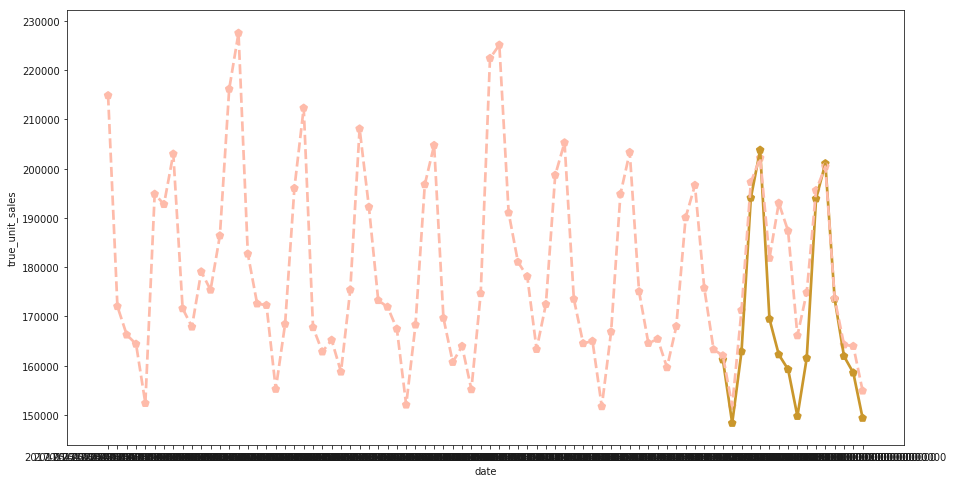

In [182]:
plt.figure(figsize=(15,8))
sns.set_color_codes("pastel")
g=sns.pointplot(x=df_plot.index, y="pred_unit_sales", data=df_plot,color='#CA972C',markers='p')
sns.pointplot(x=df_plot.index, y="true_unit_sales", data=df_plot,color='#FEBBAA',markers='p',linestyles='--')
plt.autoscale()
plt.show()